In [2]:
import numpy as np
from scipy.interpolate import spline
import basis_set_exchange as bse
from pyscf import gto,scf
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
from matplotlib import pyplot as plt
import sys
sys.path.append( '/home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/Libs')


In [3]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

In [4]:
from Morse import Morse_interpolator

In [5]:
def MorseV(r,D,a,re):
    return D*(np.exp(-2*a*(r-re))-2*np.exp(-a*(r-re)))+D

In [6]:
def Morse_dE(r,r_e,a,De):
    return De*((np.exp(a*(r_e-r))-1)**2)

## Minima for N2, CO

In [7]:
pcx2=bse.get_basis("pcX-2",fmt="nwchem",elements=[6,8])

In [8]:
mol=gto.M(atom="C 0 0 0;O 0 0 2.08272", unit="Bohr",basis=pcx2)
mf=scf.RHF(mol)
e_min=mf.scf()
mf.Gradients().grad()[1,2]

converged SCF energy = -112.786616218695
--------------- RHF gradients ---------------
         x                y                z
0 C    -0.0000000000     0.0000000000    -0.0000019315
1 O     0.0000000000    -0.0000000000     0.0000019315
----------------------------------------------


1.9314634194245173e-06

In [9]:
R0=1.9
mol=gto.M(atom="C 0 0 0;O 0 0 {}".format(R0), unit="Bohr",basis=pcx2)
mf=scf.RHF(mol)
e_co=mf.scf()
g=mf.Gradients().grad()[1,2]
h=mf.Hessian().hess()[1,1,2,2]

converged SCF energy = -112.754571293095
--------------- RHF gradients ---------------
         x                y                z
0 C     0.0000000000     0.0000000000     0.3916813613
1 O    -0.0000000000    -0.0000000000    -0.3916813613
----------------------------------------------


In [10]:
#mi=Morse_interpolator(g,h,R0,.5,e_co)
#mi.re,mi.e_min

In [11]:
ec=scf.RHF(gto.M(atom="C 0 0 0",basis=pcx2)).scf()
eo=scf.RHF(gto.M(atom="O 0 0 0",basis=pcx2)).scf()

converged SCF energy = -37.6029290136079
converged SCF energy = -74.6877238559482


In [12]:
bde=ec+eo-e_co

In [13]:
g,h,bde

(-0.39168136132109943, 2.883365492918154, 0.4639184235387859)

In [14]:
def mpa(g_,h_,R0_,De_): # Morse Potential Approximation
    Z=g_**2/(2*De_)/h_
    for i in range(3):
        t=float(np.roots([1,-2,1-2*Z,+Z])[i])
        a=g_/(2*De_)/(t*(1-t))
        dX=np.log(t)/a
        if a>0 and t>0:
            return R0_+dX,a
    return -1

In [15]:
def Morse(r,r_e,a,De,R0,e0):
    return De*((np.exp(a*(r_e-r))-1)**2-(np.exp(a*(r_e-R0))-1)**2)+e0

In [16]:
mpa(g,h,R0,bde)

(2.084074317439832, 1.2694808177774268)

In [17]:
scan_r=np.linspace(1.7,2.4,31)
#scan_e=[]
#for r in scan_r:
#    scan_e.append(scf.RHF(gto.M(atom="C 0 0 0;O 0 0 {}".format(r), unit="Bohr",basis=pcx2,verbose=0)).scf())
#np.save("scan_CO",np.asarray(scan_e))

In [18]:
scan_e=np.load("scan_CO.npy")

In [19]:
scan_r_I=np.linspace(1.7,2.4,3001)
scan_e_I=spline(scan_r,scan_e,scan_r_I)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  


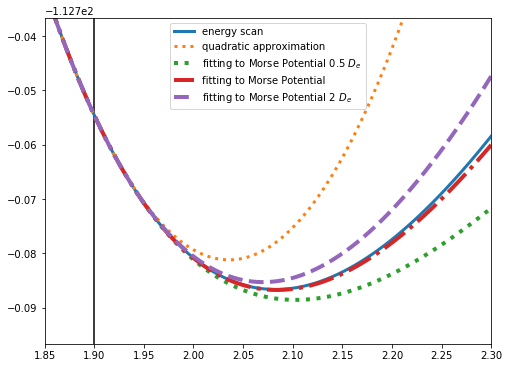

In [20]:
plt.figure(figsize=(8,6))
#plt.scatter(R0,e_co,color="black")
plt.axvline(R0,color="black")
plt.plot(scan_r_I,scan_e_I,lw=3,label="energy scan")
#plt.scatter(scan_r_I[np.asarray(scan_e_I).argmin()],min(scan_e_I),marker='|',s=2000)

q_app1=e_co+h/2*(scan_r_I-R0)**2+g*(scan_r_I-R0)

plt.plot(scan_r_I,q_app1,ls=":",lw=3,label="quadratic approximation")
#plt.scatter(scan_r_I[np.asarray(q_app1).argmin()],min(q_app1),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co ),ls=":",lw=4,\
                                         label="fitting to Morse Potential $0.5 \ D_e $")
#plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co)).argmin()],\
#            min(Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co)),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,bde) ,bde ,R0,e_co),ls="-." ,lw=4,\
                                         label="fitting to Morse Potential")
#plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,bde),bde,R0,e_co)).argmin()],\
#            min(Morse(scan_r_I, *mpa(g,h,R0,bde),bde,R0,e_co)),marker='|',s=2000)
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde ,R0,e_co),ls="--",lw=4, \
                                         label="fitting to Morse Potential $2 \ D_e $")
#plt.scatter(scan_r_I[np.asarray(Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde,R0,e_co)).argmin()],min(Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde,R0,e_co)),marker='|',s=2000)


plt.ylim(e_min-.01,e_min+.05)
plt.xlim(1.85,2.3)
plt.legend()
plt.savefig("Morse_CO_1.png")

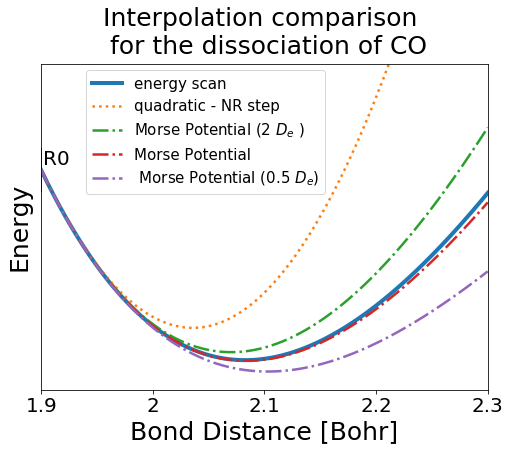

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(R0,e_co,color="black",marker='|',s=2000)
plt.text(R0+.002,e_co+.001,"R0",size=20)
plt.plot(scan_r_I,scan_e_I,lw=4,label="energy scan")

q_app1=e_co+h/2*(scan_r_I-R0)**2+g*(scan_r_I-R0)

plt.plot(scan_r_I,q_app1,ls=":",lw=2.5,label="quadratic - NR step")

plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,2*bde) ,2*bde ,R0,e_co),ls="-.",lw=2.5,\
         label="Morse Potential ($2 \ D_e $ )")
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,bde) ,bde ,R0,e_co),ls="-." ,lw=2.5,\
                                         label="Morse Potential")
plt.plot(scan_r_I,Morse(scan_r_I, *mpa(g,h,R0,.5*bde) ,.5*bde,R0,e_co ),ls="-.",lw=2.5,\
                                         label=" Morse Potential ($0.5 \ D_e $)")
plt.ylim(e_min-.005,e_min+.05)
plt.xlim(1.9,2.3)
plt.legend(fontsize=15,loc=(.1,.6))
plt.yticks([])
plt.xticks([1.9,2,2.1,2.2,2.3],labels=["1.9","2","2.1","2.2","2.3"],fontsize=20)
plt.ylabel("Energy",fontsize=25,labelpad=10)
plt.xlabel("Bond Distance [Bohr]",fontsize=25)
plt.title("Interpolation comparison \n for the dissociation of CO",fontsize=25,pad=10)
plt.savefig("Morse_CO_1.png",bbox_inches="tight")